### import

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
seg_ex_raw = pd.read_csv("music-segment.csv").drop("X", axis='columns')
seg_ex_raw.head()

,age,sex,householdIncome,milesDrive,kidsAtHome,commuteCar,drivingEnthuse,musicEnthuse,subscribeToMusic,Segment
0,61,Male,67352.564812,12074.950832,4,1,4,2,subNo,CommuteNews
1,45,Male,83628.068996,12117.101036,0,1,6,4,subNo,CommuteNews
2,57,Male,81981.298059,10159.368213,2,1,5,2,subNo,CommuteNews
3,51,Male,59355.124798,11111.651505,3,1,5,3,subYes,CommuteNews
4,55,Male,79742.752423,10576.591360,0,1,5,2,subNo,CommuteNews


### Part 1 clustering

In [3]:
seg_ex_cluster = seg_ex_raw.drop("Segment", axis='columns')

In [4]:
def seg_summ(data, group):
    # Group by the specified column and calculate the mean for each numeric column
    return data.groupby(group).mean(numeric_only=True).reset_index()

In [5]:
seg_ex_num = pd.get_dummies(seg_ex_cluster, columns=["sex", "subscribeToMusic"])

#### Hclust

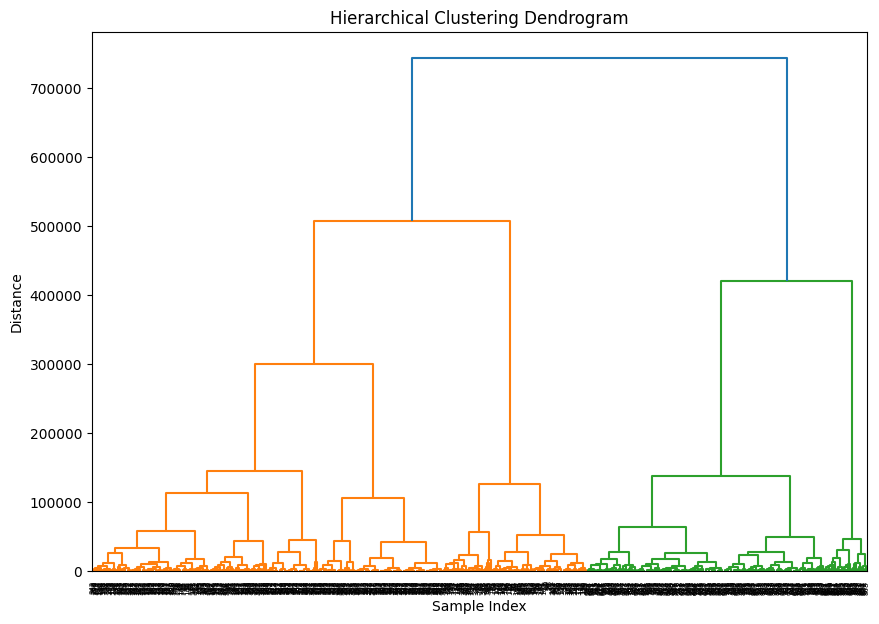

In [6]:
linked = linkage(seg_ex_num, method='ward')  # You can also use 'single', 'complete', 'average', etc.

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, 
           orientation='top', 
           labels=seg_ex_num.index.astype(str),  # Use index as labels
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [8]:
clusters = fcluster(linked, t=400000, criterion='distance')
lower_cluster = seg_ex_cluster[clusters == clusters[0]].reset_index(drop=True)
print(lower_cluster)    

     age     sex  householdIncome    milesDrive  kidsAtHome  commuteCar  \
0     61    Male     67352.564812  12074.950832           4           1   
1     51    Male     59355.124798  11111.651505           3           1   
2     62    Male     75827.069658  11440.609733           2           1   
3     52    Male     75685.104136  13241.707005           3           1   
4     47  Female     70204.876029   9845.479946           3           1   
..   ...     ...              ...           ...         ...         ...   
401   30    Male     36224.595117      0.000000           1           0   
402   31  Female     53855.860554      0.000000           1           0   
403   29    Male     54779.333052      0.000000           5           0   
404   26    Male     49509.174301  17576.520342           0           1   
405   25    Male     48863.257265  24358.635000           0           1   

     drivingEnthuse  musicEnthuse subscribeToMusic  
0                 4             2            s

#### Kmeans

In [17]:
scaler = StandardScaler()
seg_ex_num_scaled = scaler.fit_transform(seg_ex_num)

# Step 2: Run K-means clustering
n_clusters = 4  # Specify the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(seg_ex_num_scaled)

# Step 3: Get the cluster labels
seg_ex_num['cluster'] = kmeans.labels_

In [18]:
# Step 4: Run PCA decomposition
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
seg_ex_num_pca = pca.fit_transform(seg_ex_num_scaled)

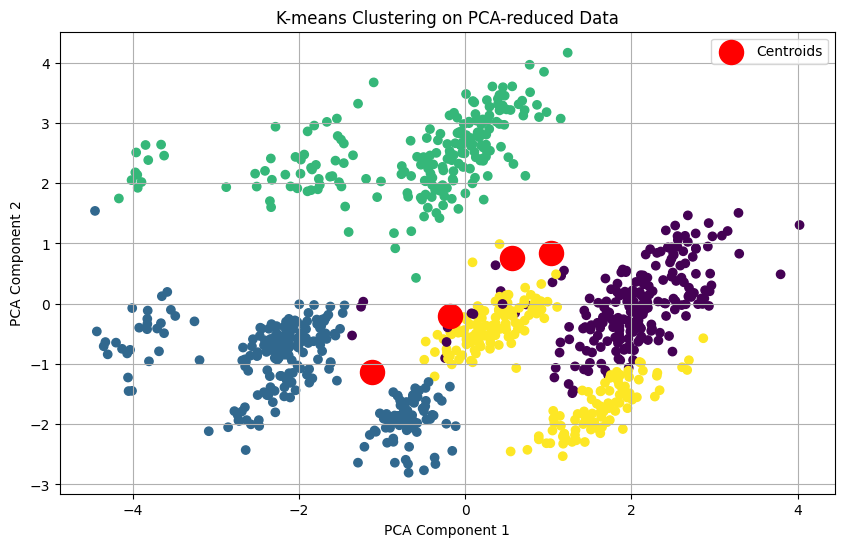

In [19]:
pca_seg_ex_num = pd.DataFrame(data=seg_ex_num_pca, columns=['PCA1', 'PCA2'])
pca_seg_ex_num['cluster'] = kmeans.labels_

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_seg_ex_num['PCA1'], pca_seg_ex_num['PCA2'], c=pca_seg_ex_num['cluster'], cmap='viridis', marker='o')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('K-means Clustering on PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid()
plt.show()

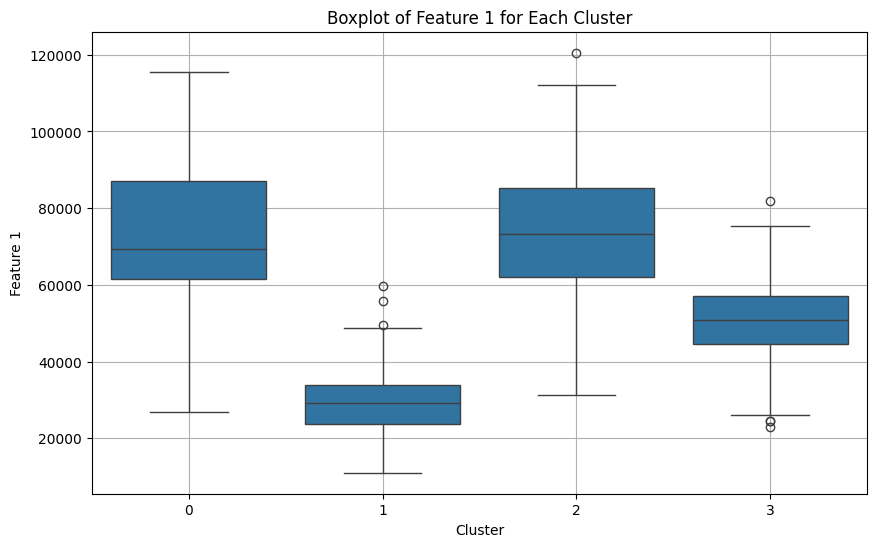

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='householdIncome', data=seg_ex_num)
plt.title('Boxplot of Feature 1 for Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feature 1')
plt.grid()
plt.show()

#### Mclust

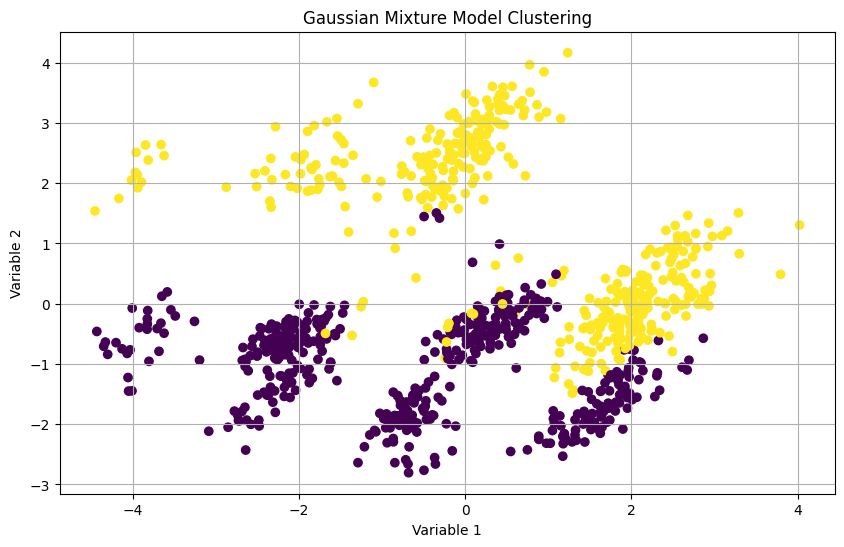

Class Probabilities:
 [[2.30915311e-25 1.00000000e+00]
 [1.12575695e-18 1.00000000e+00]
 [1.53565651e-22 1.00000000e+00]
 ...
 [5.20246410e-57 1.00000000e+00]
 [2.23535352e-49 1.00000000e+00]
 [1.40358188e-32 1.00000000e+00]]


In [55]:
n_components = 2  # Specify the number of clusters
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(seg_ex_num)

# Step 2: Predict cluster labels
seg_ex_num['cluster'] = gmm.predict(seg_ex_num)

# Step 3: Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_seg_ex_num['PCA1'], pca_seg_ex_num['PCA2'], c=seg_ex_num['cluster'], cmap='viridis', marker='o')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Variable 1')
plt.ylabel('Variable 2')
plt.grid()
plt.show()

# Class probabilities for each observation
class_probabilities = gmm.predict_proba(seg_ex_num)
print("Class Probabilities:\n", class_probabilities)

### Part 2: classification

#### Naive Bayes

In [58]:
seg_ex_cluster.head()

,age,sex,householdIncome,milesDrive,kidsAtHome,commuteCar,drivingEnthuse,musicEnthuse,subscribeToMusic
0,61,Male,67352.564812,12074.950832,4,1,4,2,subNo
1,45,Male,83628.068996,12117.101036,0,1,6,4,subNo
2,57,Male,81981.298059,10159.368213,2,1,5,2,subNo
3,51,Male,59355.124798,11111.651505,3,1,5,3,subYes
4,55,Male,79742.752423,10576.591360,0,1,5,2,subNo


In [60]:
X = seg_ex_cluster.copy()
X['sex'] = [0 if x == "Male" else 1 for x in X['sex']]
X['subscribeToMusic'] = [0 if x == "subNo" else 1 for x in X['subscribeToMusic']]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, seg_ex_raw['Segment'], test_size=0.35, random_state=2710)

# Step 3: Create the Naive Bayes model
model = GaussianNB()

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [62]:
accuracy 

0.9840764331210191

In [63]:
confusion

array([[ 62,   0,   0,   0,   0,   2],
       [  0,  44,   0,   0,   0,   0],
       [  0,   0,  18,   0,   0,   0],
       [  0,   0,   0, 101,   0,   0],
       [  0,   0,   0,   0,  67,   0],
       [  1,   2,   0,   0,   0,  17]])

In [65]:
print(report)

              precision    recall  f1-score   support

 CommuteNews       0.98      0.97      0.98        64
 KidsAndTalk       0.96      1.00      0.98        44
LongDistance       1.00      1.00      1.00        18
 MusicDriver       1.00      1.00      1.00       101
      NonCar       1.00      1.00      1.00        67
       Quiet       0.89      0.85      0.87        20

    accuracy                           0.98       314
   macro avg       0.97      0.97      0.97       314
weighted avg       0.98      0.98      0.98       314



#### Random Forest

In [68]:
model = RandomForestClassifier(n_estimators=3000, random_state=42)

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion)
print('Classification Report:')
print(report)

Accuracy: 0.97
Confusion Matrix:
[[ 61   0   0   0   0   3]
 [  0  44   0   0   0   0]
 [  0   0  18   0   0   0]
 [  0   0   0 101   0   0]
 [  0   0   0   0  67   0]
 [  0   5   0   0   0  15]]
Classification Report:
              precision    recall  f1-score   support

 CommuteNews       1.00      0.95      0.98        64
 KidsAndTalk       0.90      1.00      0.95        44
LongDistance       1.00      1.00      1.00        18
 MusicDriver       1.00      1.00      1.00       101
      NonCar       1.00      1.00      1.00        67
       Quiet       0.83      0.75      0.79        20

    accuracy                           0.97       314
   macro avg       0.96      0.95      0.95       314
weighted avg       0.98      0.97      0.97       314

